### Decision Tree Model for Wildfire Prediction - Santa Rosa Only

Based on entropy analysis from combined.ipynb, but filtered for **Santa Rosa city data only**.

**Top Features by Information Gain:**
1. NOx_ppb: 0.150431 (Best first split)
2. PM25_ugm3: 0.136348 
3. PressureAnomaly1: 0.022422
4. Avg_Pressure_in: 0.022422
5. Avg_Temp_F: 0.018999

**Features to DROP:**
- CO2_ppm (least accurate information)
- Date (not a predictive feature)
- City (already filtered, not needed)
- Climate (categorical, low predictive power)
- pm2.5 difference (derived feature, redundant)
- dispersion_ratio (non-numeric issues)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Load the interpolated dataset
df = pd.read_csv("/home/aveb7tacoma/engr697/data/combined_interpolated.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Filter for Santa Rosa only
df_sr = df[df['City'] == 'Santa Rosa'].copy()

print("Dataset loaded successfully!")
print(f"Total dataset shape: {df.shape}")
print(f"Santa Rosa filtered shape: {df_sr.shape}")
print(f"\nSanta Rosa target variable distribution:")
print(df_sr['yn'].value_counts())
print(f"\nSanta Rosa target variable percentage:")
print(df_sr['yn'].value_counts(normalize=True) * 100)
print(f"\nDate range for Santa Rosa:")
print(f"  From: {df_sr['Date'].min()}")
print(f"  To: {df_sr['Date'].max()}")


Dataset loaded successfully!
Total dataset shape: (276, 23)
Santa Rosa filtered shape: (62, 23)

Santa Rosa target variable distribution:
yn
0    38
1    24
Name: count, dtype: int64

Santa Rosa target variable percentage:
yn
0    61.290323
1    38.709677
Name: proportion, dtype: float64

Date range for Santa Rosa:
  From: 2017-10-01 00:00:00
  To: 2024-10-31 00:00:00


In [2]:
# Use Santa Rosa filtered dataset
# Define features to USE and DROP based on entropy analysis
# Features to DROP (low information gain, inaccurate, or non-predictive)
features_to_drop = [
    'Date',           # Not predictive
    'City',          # Already filtered, not needed
    'Climate',       # Categorical, low predictive power  
    'CO2_ppm',       # Least accurate information
    'pm2.5 difference',  # Derived feature, redundant
    'dispersion_ratio'   # Non-numeric issues
]

# Features to USE (based on entropy analysis ranking)
# Top features by information gain:
features_to_use = [
    'NOx_ppb',              # Rank 1: Info Gain = 0.150431
    'PM25_ugm3',            # Rank 2: Info Gain = 0.136348
    'PressureAnomaly1',     # Rank 3: Info Gain = 0.022422
    'Avg_Pressure_in',      # Rank 4: Info Gain = 0.022422
    'Avg_Temp_F',           # Rank 5: Info Gain = 0.018999
    'Min_Temp_F',           # Rank 6: Info Gain = 0.016104
    'Max_Humidity_',        # Rank 7: Info Gain = 0.013203
    'Min_Pressure_in',      # Rank 8: Info Gain = 0.010201
    'Max_Pressure_in',      # Rank 9: Info Gain = 0.006574
    'Avg_Humidity_',        # Rank 10: Info Gain = 0.005633
    'Min_Humidity_',        # Additional feature
    'Max_Wind_Speed_mph',   # Additional feature
    'Avg_Wind_Speed_mph',   # Additional feature
    'dryness_index '        # Additional feature
]

print("Features Configuration for Santa Rosa:")
print(f"\nFeatures to DROP ({len(features_to_drop)}):")
for f in features_to_drop:
    print(f"  - {f}")

print(f"\nFeatures to USE ({len(features_to_use)}):")
for i, f in enumerate(features_to_use, 1):
    print(f"  {i:2d}. {f}")

# Prepare features and target (Santa Rosa only)
X = df_sr[features_to_use].copy()
y = df_sr['yn'].copy()

# Convert all feature columns to numeric, replacing any non-numeric values with NaN
print(f"\nConverting features to numeric...")
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle any missing values
print(f"\nMissing values in features:")
missing = X.isna().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (only for numeric columns)
    X = X.fillna(X.select_dtypes(include=[np.number]).median())
    print("Filled missing values with median")
else:
    print("No missing values!")

# Ensure all columns are numeric
X = X.select_dtypes(include=[np.number])

print(f"\nFeature matrix shape (Santa Rosa): {X.shape}")
print(f"Target vector shape (Santa Rosa): {y.shape}")
print(f"\nFeature data types:")
print(X.dtypes)


Features Configuration for Santa Rosa:

Features to DROP (6):
  - Date
  - City
  - Climate
  - CO2_ppm
  - pm2.5 difference
  - dispersion_ratio

Features to USE (14):
   1. NOx_ppb
   2. PM25_ugm3
   3. PressureAnomaly1
   4. Avg_Pressure_in
   5. Avg_Temp_F
   6. Min_Temp_F
   7. Max_Humidity_
   8. Min_Pressure_in
   9. Max_Pressure_in
  10. Avg_Humidity_
  11. Min_Humidity_
  12. Max_Wind_Speed_mph
  13. Avg_Wind_Speed_mph
  14. dryness_index 

Converting features to numeric...

Missing values in features:
No missing values!

Feature matrix shape (Santa Rosa): (62, 14)
Target vector shape (Santa Rosa): (62,)

Feature data types:
NOx_ppb               float64
PM25_ugm3             float64
PressureAnomaly1      float64
Avg_Pressure_in       float64
Avg_Temp_F            float64
Min_Temp_F              int64
Max_Humidity_           int64
Min_Pressure_in       float64
Max_Pressure_in       float64
Avg_Humidity_         float64
Min_Humidity_           int64
Max_Wind_Speed_mph      int6

In [3]:
# Define decision tree layers based on entropy analysis
print("="*80)
print("DECISION TREE ARCHITECTURE - SANTA ROSA ONLY")
print("="*80)

print("""
Layer 1 (Root): NOx_ppb
  - Split at median: 0.0330
  - Highest information gain: 0.150431
  - Left branch entropy: 0.7103
  - Right branch entropy: 0.9467

Layer 2 (Left branch): PM25_ugm3
  - Second highest information gain: 0.136348
  - Split at median: 12.25
  
Layer 2 (Right branch): PM25_ugm3
  - Same feature for consistency
  - Split at median: 12.25

Layer 3+: Additional features based on information gain
  - PressureAnomaly1, Avg_Pressure_in, Avg_Temp_F, etc.
""")

# Split the data (note: smaller dataset, may need smaller test size)
test_size = 0.25 if len(X) > 50 else 0.2  # Use 25% if we have enough data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"\nSanta Rosa Training set: {X_train.shape}")
print(f"Santa Rosa Test set: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())


DECISION TREE ARCHITECTURE - SANTA ROSA ONLY

Layer 1 (Root): NOx_ppb
  - Split at median: 0.0330
  - Highest information gain: 0.150431
  - Left branch entropy: 0.7103
  - Right branch entropy: 0.9467

Layer 2 (Left branch): PM25_ugm3
  - Second highest information gain: 0.136348
  - Split at median: 12.25

Layer 2 (Right branch): PM25_ugm3
  - Same feature for consistency
  - Split at median: 12.25

Layer 3+: Additional features based on information gain
  - PressureAnomaly1, Avg_Pressure_in, Avg_Temp_F, etc.


Santa Rosa Training set: (46, 14)
Santa Rosa Test set: (16, 14)

Training target distribution:
yn
0    28
1    18
Name: count, dtype: int64

Test target distribution:
yn
0    10
1     6
Name: count, dtype: int64


In [4]:
# Build decision tree with parameters based on entropy analysis
# Use max_depth to control tree complexity
# Feature importance should align with information gain ranking

dt_model = DecisionTreeClassifier(
    criterion='entropy',           # Use entropy (same as our analysis)
    max_depth=4,                   # Limit depth to prevent overfitting
    min_samples_split=5,           # Lower for smaller dataset
    min_samples_leaf=3,            # Lower for smaller dataset
    random_state=42,
    class_weight='balanced'        # Handle class imbalance
)

# Train the model
print("Training decision tree model on Santa Rosa data...")
dt_model.fit(X_train, y_train)

# Make predictions
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nModel Performance (Santa Rosa):")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Training decision tree model on Santa Rosa data...

Model Performance (Santa Rosa):
Training Accuracy: 0.9783 (97.83%)
Test Accuracy: 0.9375 (93.75%)


FEATURE IMPORTANCE COMPARISON - SANTA ROSA

Model Feature Importance vs Entropy Analysis Ranking:
Feature                   | Model Importance   | Entropy Rank
------------------------------------------------------------
NOx_ppb                   *** |          0.585553 |            1
dryness_index             |          0.230130 |           14
Min_Pressure_in           |          0.139791 |            8
Min_Temp_F                |          0.044526 |            6
PM25_ugm3                 *** |          0.000000 |            2
PressureAnomaly1          |          0.000000 |            3
Avg_Temp_F                |          0.000000 |            5
Avg_Pressure_in           |          0.000000 |            4
Max_Pressure_in           |          0.000000 |            9
Max_Humidity_             |          0.000000 |            7
Avg_Humidity_             |          0.000000 |           10
Min_Humidity_             |          0.000000 |           11
Max_Wind_Speed_mph        |          0.

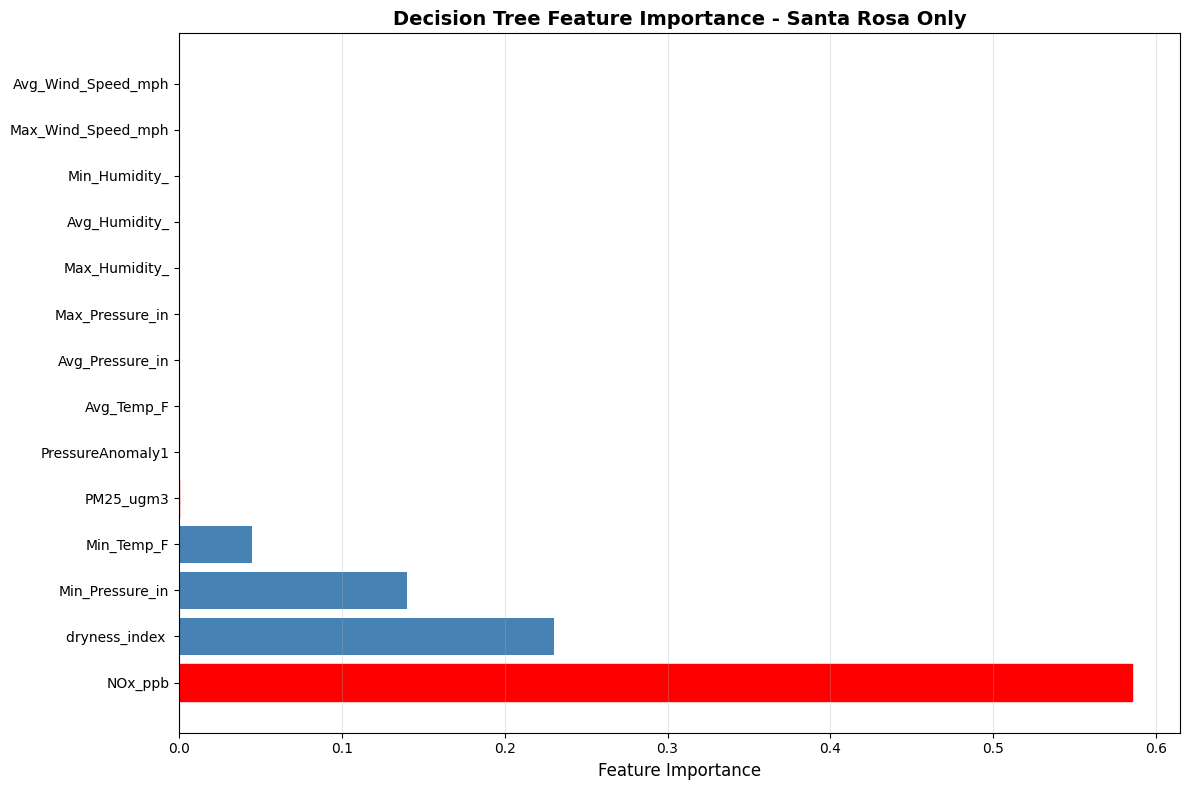

In [5]:
# Feature importance from the model vs entropy analysis
feature_importance = pd.DataFrame({
    'Feature': features_to_use,
    'Model_Importance': dt_model.feature_importances_,
    'Entropy_Rank': range(1, len(features_to_use) + 1)
}).sort_values('Model_Importance', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE COMPARISON - SANTA ROSA")
print("="*80)
print("\nModel Feature Importance vs Entropy Analysis Ranking:")
print(f"{'Feature':<25} | {'Model Importance':<18} | {'Entropy Rank':<12}")
print("-"*60)

for idx, row in feature_importance.iterrows():
    marker = " ***" if 'NOx' in row['Feature'] or 'PM25' in row['Feature'] else ""
    print(f"{row['Feature']:<25}{marker} | {row['Model_Importance']:>17.6f} | {int(row['Entropy_Rank']):>12d}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['Model_Importance'], 
                color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Decision Tree Feature Importance - Santa Rosa Only', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Highlight top features from entropy analysis
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    if 'NOx' in row['Feature'] or 'PM25' in row['Feature']:
        bars[i].set_color('red')

plt.tight_layout()
plt.show()


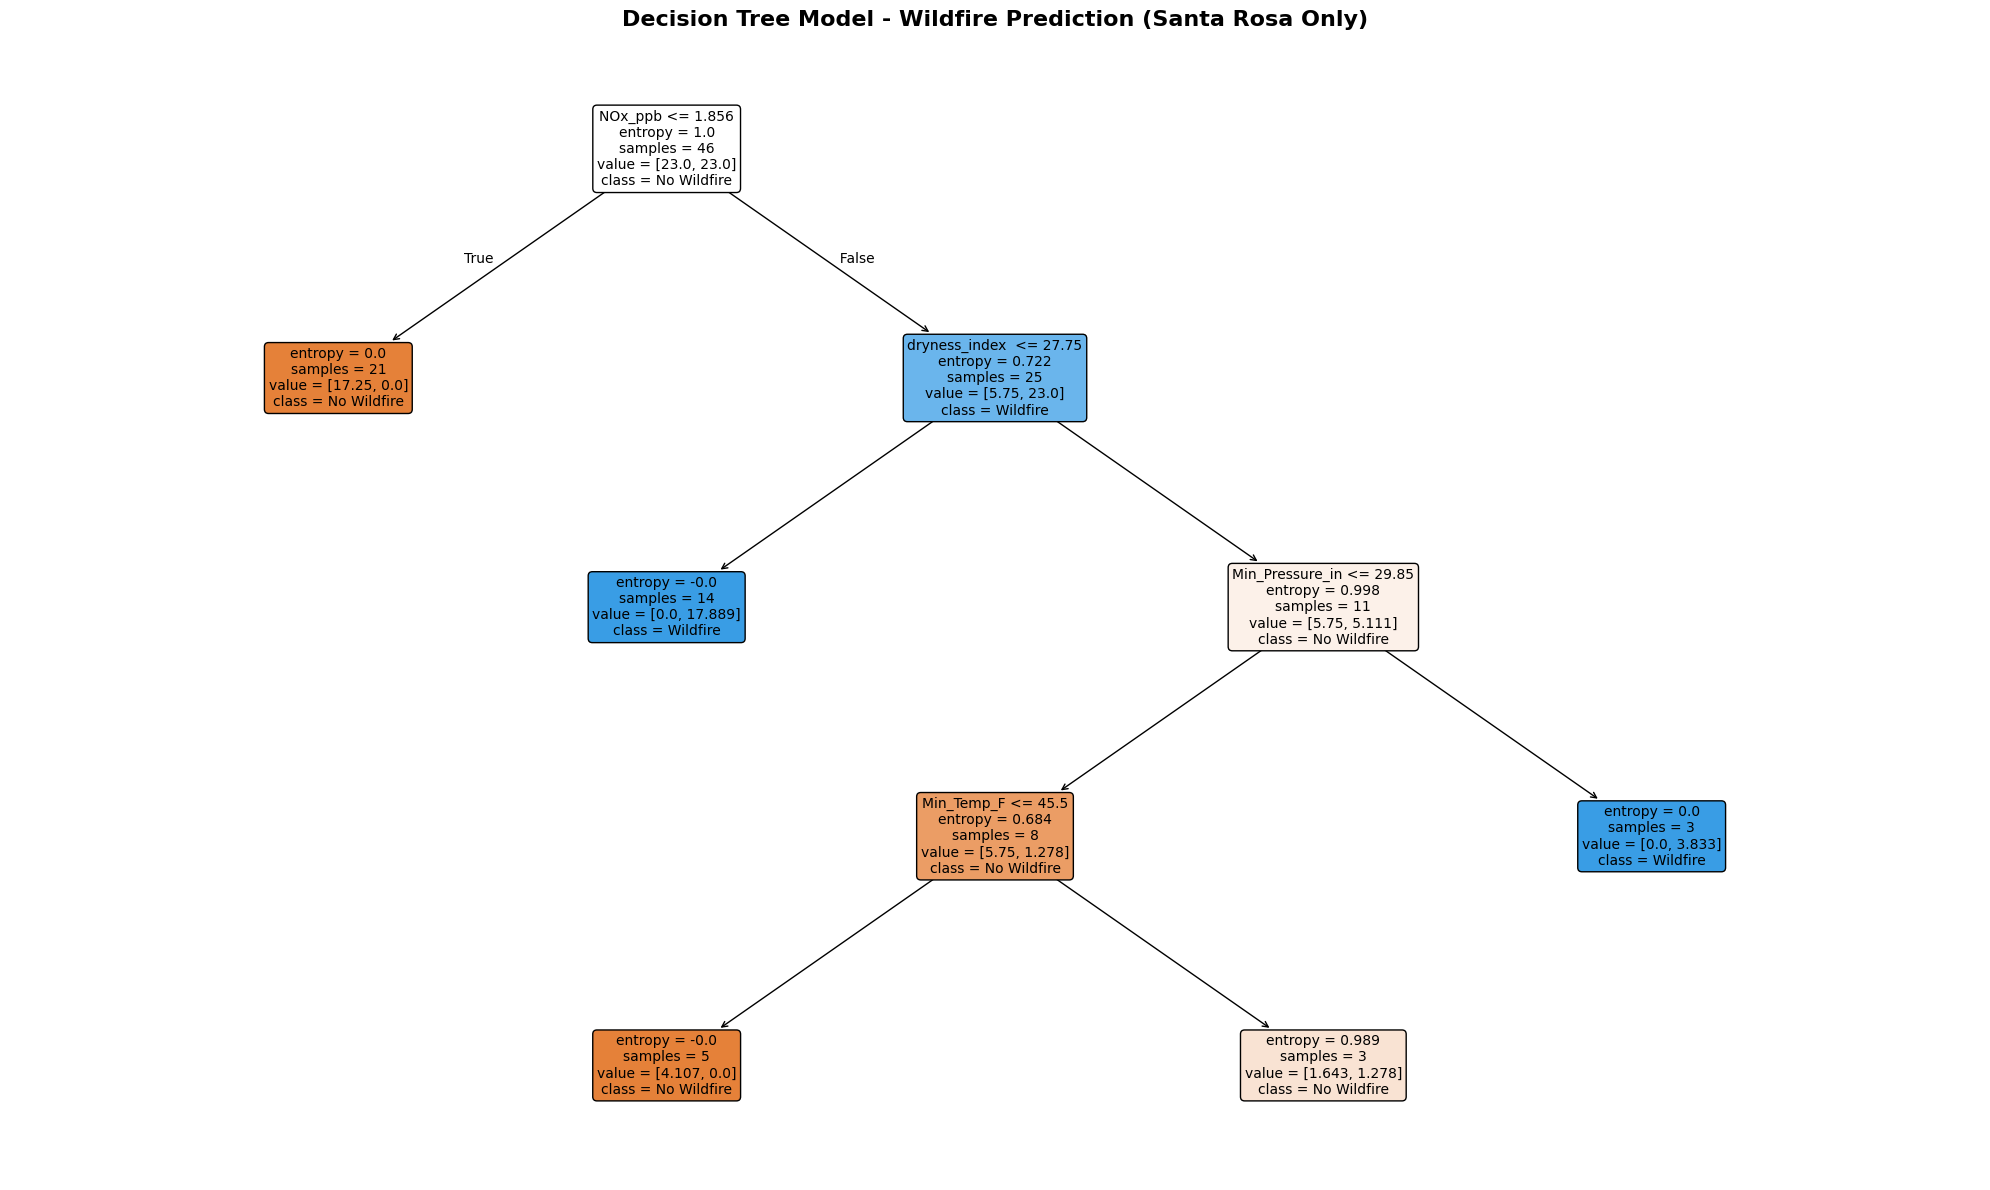

DECISION TREE STRUCTURE SUMMARY - SANTA ROSA

Tree Depth: 4
Number of Leaves: 5
Number of Features Used: 4
Total samples in training: 46
Total samples in test: 16


In [6]:
# Visualize the decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt_model, 
          feature_names=features_to_use,
          class_names=['No Wildfire', 'Wildfire'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Model - Wildfire Prediction (Santa Rosa Only)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print tree structure
print("="*80)
print("DECISION TREE STRUCTURE SUMMARY - SANTA ROSA")
print("="*80)
print(f"\nTree Depth: {dt_model.get_depth()}")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")
print(f"Number of Features Used: {np.sum(dt_model.feature_importances_ > 0)}")
print(f"Total samples in training: {len(X_train)}")
print(f"Total samples in test: {len(X_test)}")


DETAILED PERFORMANCE METRICS - SANTA ROSA

Classification Report - Test Set:
              precision    recall  f1-score   support

 No Wildfire       0.91      1.00      0.95        10
    Wildfire       1.00      0.83      0.91         6

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16


Confusion Matrix:
                 Predicted
              No WF   Wildfire
Actual No WF     10       0
       Wildfire     1       5


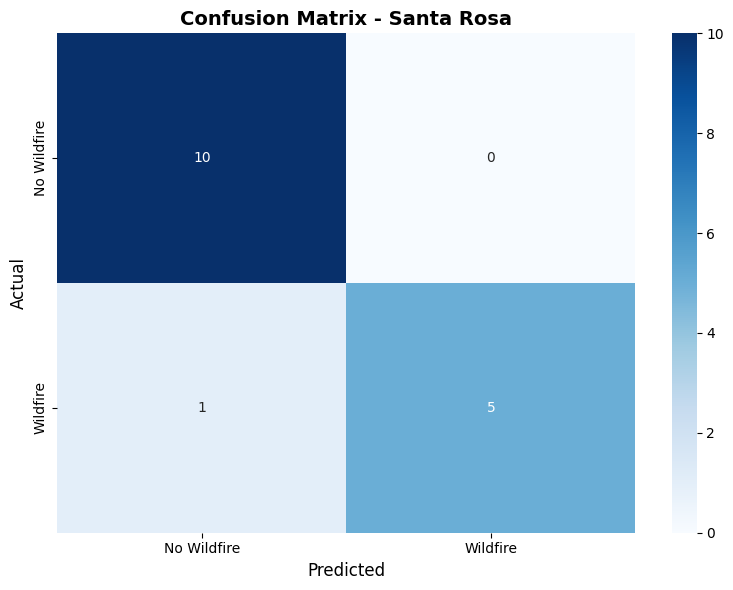


Detailed Metrics:
  Precision: 1.0000
  Recall (Sensitivity): 0.8333
  F1-Score: 0.9091


In [7]:
# Detailed performance metrics
print("="*80)
print("DETAILED PERFORMANCE METRICS - SANTA ROSA")
print("="*80)

print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred, 
                           target_names=['No Wildfire', 'Wildfire']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"              No WF   Wildfire")
print(f"Actual No WF  {cm[0,0]:5d}   {cm[0,1]:5d}")
print(f"       Wildfire {cm[1,0]:5d}   {cm[1,1]:5d}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix - Santa Rosa', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate metrics
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall (Sensitivity): {recall:.4f}")
print(f"  F1-Score: {f1_score:.4f}")


In [8]:
# Import necessary libraries for decision path analysis
import numpy as np

# Decision tree decision path analysis
# Show the actual decision rules for key paths
print("="*80)
print("KEY DECISION PATHS IN THE TREE - SANTA ROSA")
print("="*80)

# Check if model has been trained
if not hasattr(dt_model, 'tree_') and not hasattr(dt_model, '_tree'):
    print("\nERROR: Model has not been trained yet. Please run cell 4 first.")
else:
    # Get the tree structure (compatible with different sklearn versions)
    try:
        tree = dt_model.tree_
    except AttributeError:
        tree = dt_model._tree
    
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold
    value = tree.value

    def get_path(node, depth=0, path="", max_depth=3):
        """Recursively get decision paths"""
        if depth > max_depth:
            return
        indent = "  " * depth
        if children_left[node] == children_right[node]:  # Leaf node
            samples = int(value[node].sum())
            class_dist = value[node][0]
            pred_class = int(np.argmax(class_dist))
            confidence = class_dist[pred_class] / class_dist.sum()
            print(f"{indent}→ Leaf: Predict {'Wildfire' if pred_class == 1 else 'No Wildfire'}")
            print(f"{indent}  Samples: {samples}, Confidence: {confidence:.2%}")
            return
        else:  # Decision node
            feat_idx = feature[node]
            if feat_idx >= 0:  # Valid feature index
                feat_name = features_to_use[feat_idx]
                thresh = threshold[node]
                print(f"{indent}Node {node}: {feat_name} <= {thresh:.4f}")
                get_path(children_left[node], depth + 1, path + f" {feat_name} <= {thresh:.4f}", max_depth)
                print(f"{indent}Node {node}: {feat_name} > {thresh:.4f}")
                get_path(children_right[node], depth + 1, path + f" {feat_name} > {thresh:.4f}", max_depth)

    # Show first few levels
    print("\nDecision Tree Paths (first 3 levels):")
    get_path(0, depth=0, max_depth=3)


KEY DECISION PATHS IN THE TREE - SANTA ROSA

Decision Tree Paths (first 3 levels):
Node 0: NOx_ppb <= 1.8555
  → Leaf: Predict No Wildfire
    Samples: 1, Confidence: 100.00%
Node 0: NOx_ppb > 1.8555
  Node 2: dryness_index  <= 27.7500
    → Leaf: Predict Wildfire
      Samples: 1, Confidence: 100.00%
  Node 2: dryness_index  > 27.7500
    Node 4: Min_Pressure_in <= 29.8500
      Node 5: Min_Temp_F <= 45.5000
      Node 5: Min_Temp_F > 45.5000
    Node 4: Min_Pressure_in > 29.8500
      → Leaf: Predict Wildfire
        Samples: 1, Confidence: 100.00%


In [9]:
# Summary of Decision Tree Layers
print("="*80)
print("DECISION TREE LAYERS SUMMARY - SANTA ROSA")
print("="*80)

# Check if model has been trained
if not hasattr(dt_model, 'tree_') and not hasattr(dt_model, '_tree'):
    print("\nERROR: Model has not been trained yet. Please run cell 4 first.")
else:
    # Get the tree structure (compatible with different sklearn versions)
    try:
        tree = dt_model.tree_
    except AttributeError:
        tree = dt_model._tree
    
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold
    value = tree.value

    # Get simplified tree structure
    def print_tree_structure(node, depth=0, max_depth=3):
        """Print tree structure up to max_depth"""
        if depth > max_depth:
            return
        
        indent = "  " * depth
        
        if children_left[node] == children_right[node]:  # Leaf
            samples = int(value[node].sum())
            class_dist = value[node][0]
            pred_class = int(np.argmax(class_dist))
            confidence = class_dist[pred_class] / class_dist.sum()
            print(f"{indent}→ {'Wildfire' if pred_class == 1 else 'No Wildfire'} (n={samples}, conf={confidence:.1%})")
        else:
            feat_idx = feature[node]
            if feat_idx >= 0:  # Valid feature index
                feat_name = features_to_use[feat_idx]
                thresh = threshold[node]
                print(f"{indent}Layer {depth+1}: {feat_name} <= {thresh:.4f}")
                print_tree_structure(children_left[node], depth + 1, max_depth)
                print(f"{indent}Layer {depth+1}: {feat_name} > {thresh:.4f}")
                print_tree_structure(children_right[node], depth + 1, max_depth)

    print("\nDecision Tree Structure (first 3 layers):")
    print_tree_structure(0, depth=0, max_depth=3)

    print("\n" + "="*80)
    print("FEATURE USAGE SUMMARY - SANTA ROSA")
    print("="*80)
    features_used = [features_to_use[i] for i in feature if i >= 0]
    unique_features = set(features_used)
    print(f"\nUnique features used in tree: {len(unique_features)}")
    for i, feat in enumerate(sorted(unique_features), 1):
        usage_count = features_used.count(feat)
        if feat in features_to_use:
            importance = dt_model.feature_importances_[features_to_use.index(feat)]
            print(f"  {i}. {feat}: Used {usage_count} time(s), Importance: {importance:.4f}")


DECISION TREE LAYERS SUMMARY - SANTA ROSA

Decision Tree Structure (first 3 layers):
Layer 1: NOx_ppb <= 1.8555
  → No Wildfire (n=1, conf=100.0%)
Layer 1: NOx_ppb > 1.8555
  Layer 2: dryness_index  <= 27.7500
    → Wildfire (n=1, conf=100.0%)
  Layer 2: dryness_index  > 27.7500
    Layer 3: Min_Pressure_in <= 29.8500
      Layer 4: Min_Temp_F <= 45.5000
      Layer 4: Min_Temp_F > 45.5000
    Layer 3: Min_Pressure_in > 29.8500
      → Wildfire (n=1, conf=100.0%)

FEATURE USAGE SUMMARY - SANTA ROSA

Unique features used in tree: 4
  1. Min_Pressure_in: Used 1 time(s), Importance: 0.1398
  2. Min_Temp_F: Used 1 time(s), Importance: 0.0445
  3. NOx_ppb: Used 1 time(s), Importance: 0.5856
  4. dryness_index : Used 1 time(s), Importance: 0.2301


In [10]:
# Model Summary and Final Statistics - Santa Rosa
print("="*80)
print("MODEL SUMMARY - SANTA ROSA ONLY")
print("="*80)

if hasattr(dt_model, 'tree_') or hasattr(dt_model, '_tree'):
    print(f"\nModel successfully trained on Santa Rosa data!")
    print(f"Dataset size: {len(df_sr)} samples")
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"\nTree Depth: {dt_model.get_depth()}")
    print(f"Number of Leaves: {dt_model.get_n_leaves()}")
    print(f"Number of Features Used: {np.sum(dt_model.feature_importances_ > 0)}")
    
    print(f"\nTop 5 Most Important Features for Santa Rosa:")
    top_features = pd.DataFrame({
        'Feature': features_to_use,
        'Importance': dt_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(5)
    
    for idx, row in top_features.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
    
    print(f"\nSanta Rosa Data Distribution:")
    print(f"  Wildfire days (yn=1): {(df_sr['yn'] == 1).sum()} ({(df_sr['yn'] == 1).sum()/len(df_sr)*100:.1f}%)")
    print(f"  No Wildfire days (yn=0): {(df_sr['yn'] == 0).sum()} ({(df_sr['yn'] == 0).sum()/len(df_sr)*100:.1f}%)")
else:
    print("\nModel has not been trained yet. Please run cells 1-4 first.")


MODEL SUMMARY - SANTA ROSA ONLY

Model successfully trained on Santa Rosa data!
Dataset size: 62 samples
Training set: 46 samples
Test set: 16 samples

Training Accuracy: 0.9783 (97.83%)
Test Accuracy: 0.9375 (93.75%)

Tree Depth: 4
Number of Leaves: 5
Number of Features Used: 4

Top 5 Most Important Features for Santa Rosa:
  NOx_ppb: 0.5856
  dryness_index : 0.2301
  Min_Pressure_in: 0.1398
  Min_Temp_F: 0.0445
  PM25_ugm3: 0.0000

Santa Rosa Data Distribution:
  Wildfire days (yn=1): 24 (38.7%)
  No Wildfire days (yn=0): 38 (61.3%)
